In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import os
from tqdm import *
import sklearn
from scipy.ndimage import imread
import random
from sklearn.metrics import *
import itertools

plt.ion()
plt.show()

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

doMnist = True

Using TensorFlow backend.


In [2]:
# load dataset
if doMnist == True:
    imgsize = 28
    imgchannels = 1

    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    
    print(X_train.shape)
else:
    imgsize = 250 # 250 (5*5*5*2)
    imgchannels = 3
    lfwX, lfwDF = load_lfw()


11386880/11490434 [============================>.] - ETA: 15 - ETA: 63s - ETA: 66 - ETA: 47 - ETA: 35 - ETA: 32 - ETA: 25 - ETA: 20 - ETA: 16 - ETA: 15 - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA: 0s(60000, 28, 28, 1)


In [3]:
X_train.shape

(60000, 28, 28, 1)

In [4]:
def load_lfw():
    df= pd.DataFrame()

    fullPaths = []
    baseDataFolder = 'datasets/lfw/'
    fullNames = 'lfw-names.txt'

    dataFolder = baseDataFolder + 'lfw_funneled/'
    dirList = os.listdir(dataFolder) # current directory
    for personName in dirList:
        if os.path.isdir(dataFolder+personName) == True:
            personFolder = os.listdir(dataFolder + personName)
            for img in personFolder:
                if os.path.isfile(dataFolder + personName+'/'+img):
                    fullPaths.append(dataFolder+personName+'/'+ img)
                    df = df.append([(personName, dataFolder+personName+'/'+ img, img[:-4])])

    df.columns = ['person', 'imgpath', 'img']
    df.head()
    df=df.reset_index()
    
    df['superpixels'] = ''
    dataFolder = baseDataFolder + 'parts_lfw_funneled_superpixels_mat/'

    for i, row in df.iterrows():
        if os.path.isfile(dataFolder+row.person + '/'+row.img + '.dat'):
            df.loc[i,'superpixels'] = dataFolder+row.person + '/'+row.img + '.dat'

    df['spsegfeatures'] = ''
    dataFolder = baseDataFolder + 'parts_lfw_funneled_spseg_features/'

    for i, row in df.iterrows():
        if os.path.isfile(dataFolder+row.person + '/'+row.img + '.dat'):
            df.loc[i,'spsegfeatures'] = dataFolder+row.person + '/'+row.img + '.dat'

    df['gt'] = ''
    dataFolder = baseDataFolder + 'parts_lfw_funneled_gt/'

    for i, row in df.iterrows():
        if os.path.isfile(dataFolder+row.person + '/'+row.img + '.dat'):
            df.loc[i,'gt'] = dataFolder+row.person + '/'+row.img + '.dat'

    df['gtimages'] = ''
    dataFolder = baseDataFolder + 'parts_lfw_funneled_gt_images/'

    for i, row in df.iterrows():
        if os.path.isfile(dataFolder+row.person + '/'+row.img + '.dat'):
            df.loc[i,'gtimages'] = dataFolder+row.person + '/'+row.img + '.dat'
    
    X_train = np.stack([imread(i)/255 for i in df.imgpath.values])
    
    return X_train, df

In [4]:
def build_generator():

    noise_shape = (100,)

    noise = Input(shape=noise_shape)
    x = Dense(256, input_shape=noise_shape)(noise)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(np.prod(img_shape), activation='tanh')(x)
    x = Reshape(img_shape)(x) # defined outside

    img = x

    return Model(noise, img)

In [5]:
def build_discriminator():

    inputShape = (imgsize, imgsize, imgchannels)

    inp = Input(shape=inputShape)
    x = inp
    x = Flatten(input_shape=img_shape)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    validity = x

    return Model(inp, validity)

In [6]:
img_shape = (imgsize, imgsize, imgchannels)

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

# Build and compile the generator
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# The generator takes noise as input and generated imgs
z = Input(shape=(100,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [7]:
def generate_samples(numSamples=4, subplotOffset = 0):
    noise = np.random.normal(0, 1, (numSamples, 100))
    gen_imgs = generator.predict(noise)
    
    rows = (numSamples+subplotOffset)//5+1
    cols = min((numSamples+subplotOffset),5)
    for i in range(numSamples):
        plt.subplot(rows, cols, subplotOffset+i+1)
        if ( imgchannels == 3):
            plt.imshow(gen_imgs[i])
        else:
            plt.imshow(gen_imgs[i][:,:,0], cmap='gray')
        
    return rows, cols

def plotAccuracyAndSamples(epoch, save_samples = True, save_prefix='saveFolder/'):
    plt.figure(accuracyFig.number)
    plt.clf()
    plt.plot(dLosses, label='Discriminator Loss')
    plt.plot(gLosses, label='Generator Loss')
    plt.show()
    plt.legend()
    accuracyFig.canvas.draw()

    plt.figure(sampleFig.number)
    plt.clf()
    r, c = generate_samples(20, 0)            
    sampleFig.canvas.draw()
    sampleFig.savefig(save_prefix + '{:05d}.png'.format(epoch))


In [8]:
dLosses = []
dAcc    = []
gLosses = []

def train(epochs, batch_size=128, update_interval=50, plot=True, save_samples = False, save_prefix='saveFolder/'):
    half_batch = int(batch_size / 2)

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, 100))

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        valid_y = np.array([1] * batch_size)

        # Train the generator
        g_loss = combined.train_on_batch(noise, valid_y)

        # Plot the progress
#         print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        if epoch%10==0:
            print('.', end='', flush=True)
        if epoch%1000==0:
            print("\n", end='', flush=True)
        
        dLosses.append(d_loss[0])
        dAcc.append(100%d_loss[1])
        gLosses.append(g_loss)
        
        
        if (plot==True and epoch%update_interval == 0):
            plotAccuracyAndSamples(epoch, save_samples, save_prefix)

In [9]:
plt.ion()

In [10]:
%matplotlib notebook

<IPython.core.display.Javascript object>


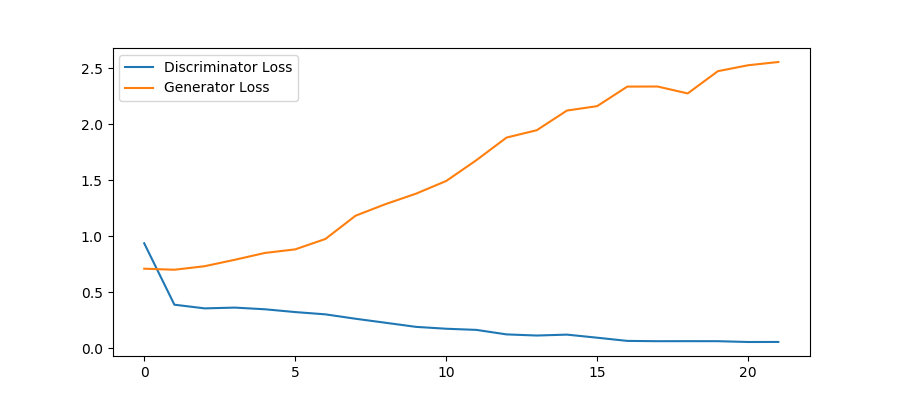

In [11]:
accuracyFig = plt.figure(figsize=(9,4))
accuracyFig.clf()

<IPython.core.display.Javascript object>


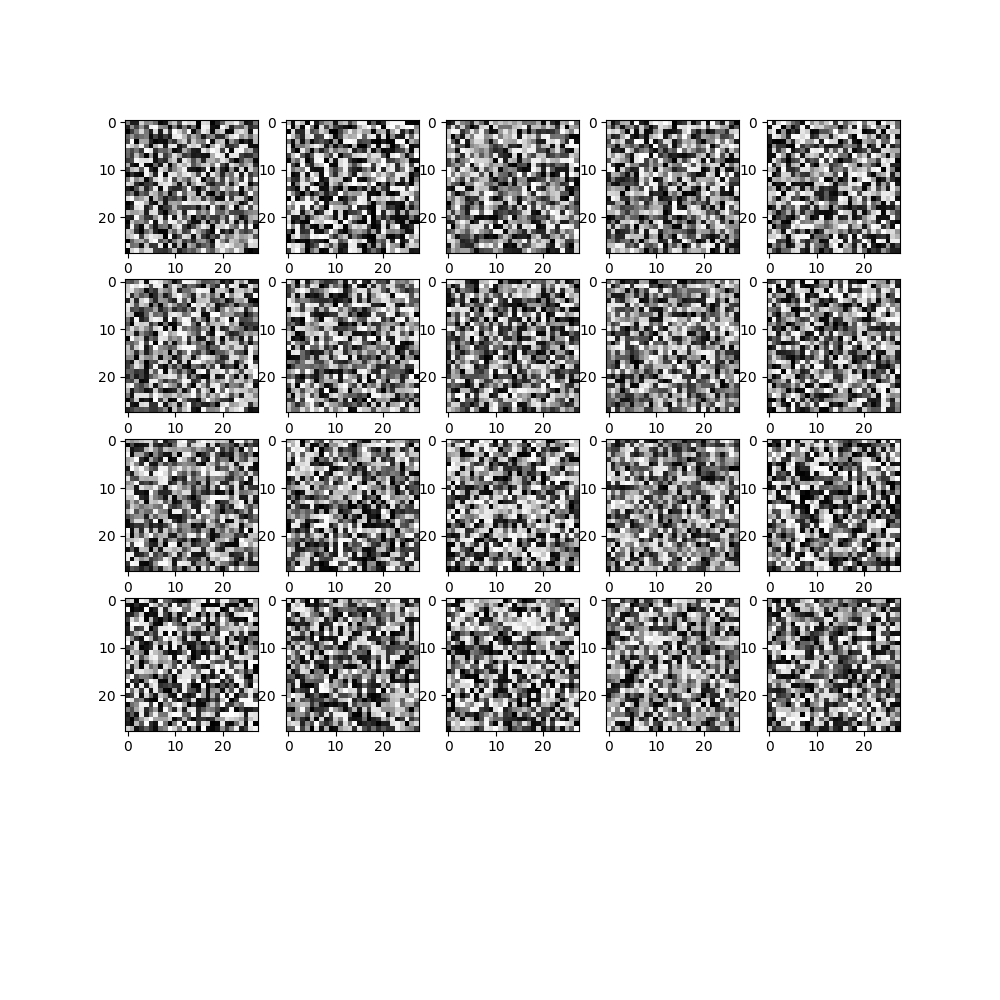

In [12]:
sampleFig = plt.figure(figsize=(10,10))
r, c = generate_samples(20, 0)
plt.subplot(r, c, 1)


In [18]:
# train(epochs=30000, batch_size=32, update_interval=200, save_samples=True, save_prefix='saveFolder/mnistGAN1-')/
train(epochs=5, batch_size=32, update_interval=200)

.
